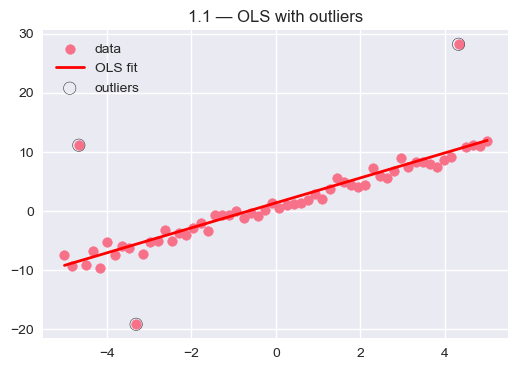

In [16]:
# EN3150 Assignment 02 — Complete Notebook 


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs

np.random.seed(0)

# -------------------------
# Section 1: Linear Regression
# -------------------------

# 1.1 — OLS fit with outliers
np.random.seed(1)
n = 60
x = np.linspace(-5, 5, n)
y = 2.0 * x + 1.0 + np.random.normal(scale=1.0, size=n)
outlier_idx = [2, 10, 55]
y[outlier_idx] += np.array([20, -15, 18])
X = x.reshape(-1,1)

ols = LinearRegression().fit(X, y)
yhat_ols = ols.predict(X)

plt.figure(figsize=(6,4))
plt.scatter(x, y, label='data')
plt.plot(x, yhat_ols, 'r-', label='OLS fit', linewidth=2)
plt.scatter(x[outlier_idx], y[outlier_idx], s=80, facecolors='none', edgecolors='k', label='outliers')
plt.legend()
plt.title('1.1 — OLS with outliers')
plt.show()





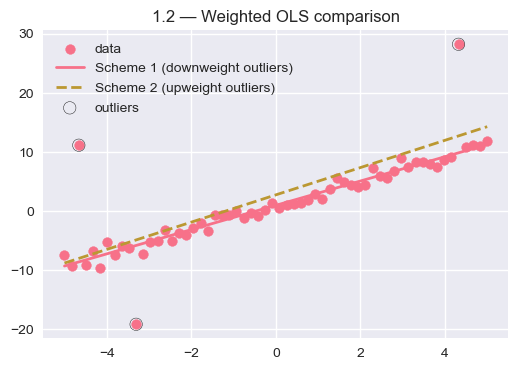

In [17]:
# 1.2 — Weighted OLS Schemes
def weighted_linear_regression(X, y, weights):
    X_aug = np.hstack([np.ones((X.shape[0],1)), X])
    W = np.diag(weights)
    A = X_aug.T.dot(W).dot(X_aug)
    b = X_aug.T.dot(W).dot(y)
    return np.linalg.solve(A, b)

weights1 = np.ones_like(y); weights1[outlier_idx] = 0.01
weights2 = np.ones_like(y); weights2[outlier_idx] = 5.0

coef1 = weighted_linear_regression(X, y, weights1)
coef2 = weighted_linear_regression(X, y, weights2)

Xg = np.linspace(x.min(), x.max(), 200).reshape(-1,1)
Xg_aug = np.hstack([np.ones((Xg.shape[0],1)), Xg])
y1 = Xg_aug.dot(coef1); y2 = Xg_aug.dot(coef2)


plt.figure(figsize=(6,4))
plt.scatter(x, y, label='data')
plt.plot(Xg, y1, label='Scheme 1 (downweight outliers)', linewidth=2)
plt.plot(Xg, y2, label='Scheme 2 (upweight outliers)', linewidth=2, linestyle='--')
plt.scatter(x[outlier_idx], y[outlier_idx], s=80, facecolors='none', edgecolors='k', label='outliers')
plt.legend()
plt.title('1.2 — Weighted OLS comparison')
plt.show()

# 1.3 — (Conceptual answer, no plot needed)

# 1.4–1.5 — (Conceptual answer, no plot needed)




2.2 — saga accuracy (no scaling): 0.6976744186046512


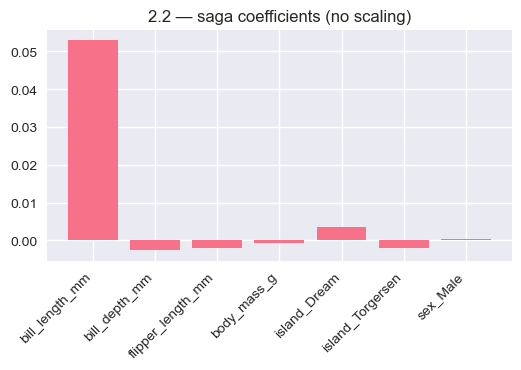

In [18]:
# -------------------------
# Section 2: Logistic Regression
# -------------------------

# 2.1 — Load penguins dataset
df = sns.load_dataset("penguins")
df = df.dropna()
df.columns = df.columns.str.strip()
df2 = df[df['species'].isin(['Adelie','Chinstrap'])].copy().reset_index(drop=True)

# 2.2 — Prepare X, y
numeric_cols = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
categorical_cols = ['island','sex']
X = pd.concat([df2[numeric_cols].reset_index(drop=True),
               pd.get_dummies(df2[categorical_cols], drop_first=True).reset_index(drop=True)], axis=1)
y = (df2['species']=='Chinstrap').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# saga without scaling
logreg_saga = LogisticRegression(solver='saga', max_iter=2000, random_state=0)
logreg_saga.fit(X_train, y_train)
acc_saga = accuracy_score(y_test, logreg_saga.predict(X_test))
print("2.2 — saga accuracy (no scaling):", acc_saga)

plt.figure(figsize=(6,3))
plt.bar(X.columns, logreg_saga.coef_.ravel())
plt.xticks(rotation=45, ha='right')
plt.title("2.2 — saga coefficients (no scaling)")
plt.show()


2.3 — saga accuracy after scaling: 1.0
2.4 — liblinear accuracy (no scaling): 0.9767441860465116


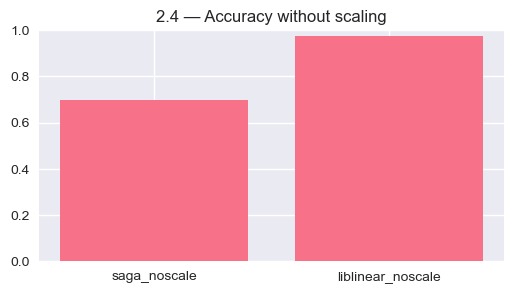

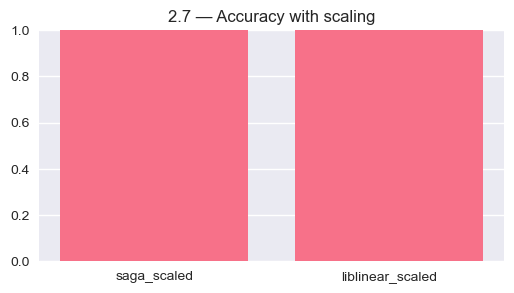

In [19]:

# 2.3 — saga with scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)
logreg_saga_s = LogisticRegression(solver='saga', max_iter=2000, random_state=0)
logreg_saga_s.fit(X_train_s, y_train)
acc_saga_s = accuracy_score(y_test, logreg_saga_s.predict(X_test_s))
print("2.3 — saga accuracy after scaling:", acc_saga_s)


# 2.4 — liblinear without scaling
logreg_lib = LogisticRegression(solver='liblinear', random_state=0)
logreg_lib.fit(X_train, y_train)
acc_lib = accuracy_score(y_test, logreg_lib.predict(X_test))
print("2.4 — liblinear accuracy (no scaling):", acc_lib)

plt.figure(figsize=(6,3))
plt.bar(['saga_noscale','liblinear_noscale'], [acc_saga, acc_lib])
plt.ylim(0,1)
plt.title("2.4 — Accuracy without scaling")
plt.show()

plt.figure(figsize=(6,3))
plt.bar(['saga_scaled','liblinear_scaled'],
        [acc_saga_s, accuracy_score(y_test, LogisticRegression(solver='liblinear').fit(X_train_s,y_train).predict(X_test_s))])
plt.ylim(0,1)
plt.title("2.7 — Accuracy with scaling")
plt.show()



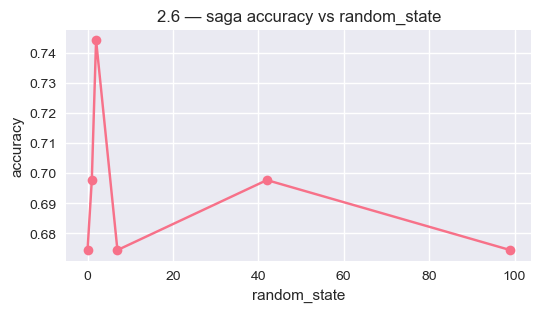

2.8 — Label encoding mapping: {np.str_('blue'): 0, np.str_('green'): 1, np.str_('red'): 2}
Encoded values: [2 0 1 0 1]
Scaled values: [1.  0.  0.5 0.  0.5]


In [20]:

# 2.6 — Variation with random_state
seeds = [0,1,2,7,42,99]
accs = []
for s in seeds:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=s, stratify=y)
    clf = LogisticRegression(solver='saga', max_iter=2000, random_state=0).fit(Xtr, ytr)
    accs.append(accuracy_score(yte, clf.predict(Xte)))

plt.figure(figsize=(6,3))
plt.plot(seeds, accs, marker='o')
plt.title("2.6 — saga accuracy vs random_state")
plt.xlabel("random_state"); plt.ylabel("accuracy")
plt.show()

# 2.8 — Label encoding demo
cats = np.array(['red','blue','green','blue','green'])
le = LabelEncoder(); vals = le.fit_transform(cats)
sc = MinMaxScaler(); vals_scaled = sc.fit_transform(vals.reshape(-1,1)).ravel()
print("2.8 — Label encoding mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
print("Encoded values:", vals)
print("Scaled values:", vals_scaled)


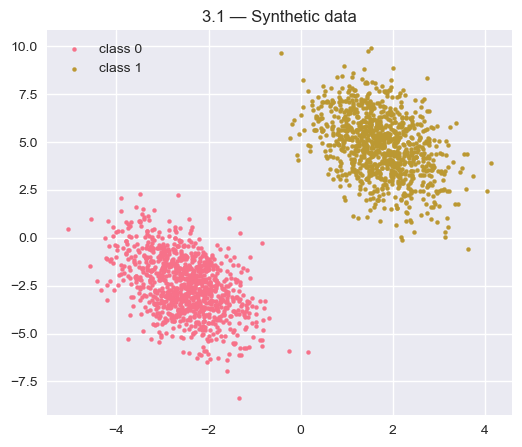

In [21]:
# -------------------------
# Section 3: First/Second-order Methods
# -------------------------

# 3.1 — Generate synthetic data
centers = [[-5,0],[5,1.5]]
X_blob, y_blob = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = np.array([[0.5,0.5],[-0.5,1.5]])
X_blob = X_blob.dot(transformation); y_blob = (y_blob==1).astype(int)

plt.figure(figsize=(6,5))
plt.scatter(X_blob[y_blob==0,0], X_blob[y_blob==0,1], s=8, label='class 0')
plt.scatter(X_blob[y_blob==1,0], X_blob[y_blob==1,1], s=8, label='class 1')
plt.legend(); plt.title("3.1 — Synthetic data")
plt.show()



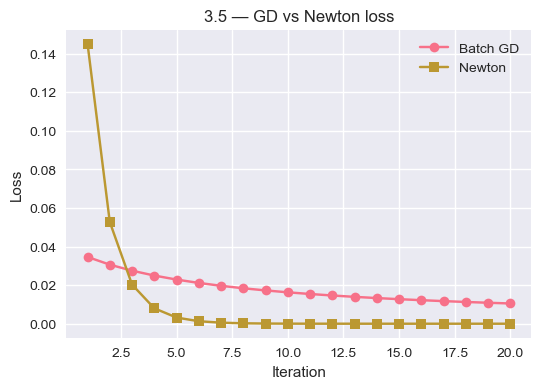

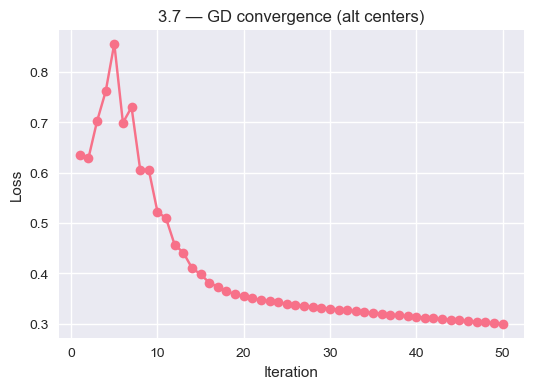

In [22]:
# Helpers
def add_bias(X): return np.hstack([np.ones((X.shape[0],1)), X])
def sigmoid(z): return 1.0/(1.0+np.exp(-z))
def logistic_loss(w, Xb, y):
    p = sigmoid(Xb.dot(w)); eps=1e-12
    return -np.mean(y*np.log(p+eps)+(1-y)*np.log(1-p+eps))
def grad_logistic(w, Xb, y):
    p = sigmoid(Xb.dot(w)); return Xb.T.dot(p-y)/Xb.shape[0]
def hessian_logistic(w, Xb, y):
    p = sigmoid(Xb.dot(w)); R = p*(1-p)
    return (Xb.T * R).dot(Xb)/Xb.shape[0]

Xb = add_bias(X_blob)

# 3.2 — Batch GD (20 iters)
w_gd = np.zeros(Xb.shape[1]); eta=0.5
loss_gd=[]
for it in range(20):
    g = grad_logistic(w_gd,Xb,y_blob)
    w_gd -= eta*g
    loss_gd.append(logistic_loss(w_gd,Xb,y_blob))

# 3.4 — Newton’s method (20 iters)

w_newton = np.zeros(Xb.shape[1]); loss_newton=[]
for it in range(20):
    g = grad_logistic(w_newton,Xb,y_blob)
    H = hessian_logistic(w_newton,Xb,y_blob)+1e-6*np.eye(Xb.shape[1])
    delta = np.linalg.solve(H,g)
    w_newton -= delta
    loss_newton.append(logistic_loss(w_newton,Xb,y_blob))

# 3.5 — Loss plot
plt.figure(figsize=(6,4))
plt.plot(range(1,21), loss_gd, marker='o', label='Batch GD')
plt.plot(range(1,21), loss_newton, marker='s', label='Newton')
plt.xlabel('Iteration'); plt.ylabel('Loss'); plt.legend()
plt.title('3.5 — GD vs Newton loss')
plt.show()


# 3.7 — Alternate centers
centers2=[[2,2],[5,1.5]]
X2,y2=make_blobs(n_samples=2000,centers=centers2,random_state=5)
X2=X2.dot(transformation); y2=(y2==1).astype(int); X2b=add_bias(X2)
w_gd2=np.zeros(X2b.shape[1]); loss_gd2=[]
for it in range(50):
    g=grad_logistic(w_gd2,X2b,y2)
    w_gd2-=eta*g
    loss_gd2.append(logistic_loss(w_gd2,X2b,y2))

plt.figure(figsize=(6,4))
plt.plot(range(1,51),loss_gd2,marker='o')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.title('3.7 — GD convergence (alt centers)')
plt.show()
